In [1]:
# Import libraries
import pandas as pd
import numpy as np
import lightgbm as lgb

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error

from utilities import data_basic_utility as databasic
from utilities import dataframe_utility as dfutil
import features_utility as featutil

## File Details - Light GBM Regression on Beer Context columns inc review counts

This is a Candidate for being used in an Ensemble. 
Characteristicts:
* Light GBM Regression Algorithm
* Using Beer Context columns inc ABV, Year and Review Counts
* Todo: use optimised parameters for Light GBM Regression


In [2]:
filePrefix = "A3_063_lgbm_regression_consumercontext"
baseDataDir = "C:/Development/Data/COSC2670/Assignment3/A3data/"
subrunDir = "subruns/"
writeSubRunFile = True
seed = databasic.get_random_seed()

In [3]:
# RowID  BeerID  ReviewerID  BeerName  BeerType  Label
# df_train = pd.read_csv(baseDataDir + 'train_500k.tsv',sep='\t',
df_train = pd.read_csv(baseDataDir + 'train_200k.tsv',sep='\t',
                         names=['RowID','BeerID','ReviewerID',
                                  'BeerName','BeerType','rating'])
df_train.head(10)

# df_vali = pd.read_csv(baseDataDir + 'vali_500k.tsv',sep='\t',
df_vali = pd.read_csv(baseDataDir + 'vali_200k.tsv',sep='\t',
                         names=['RowID','BeerID','ReviewerID',
                                  'BeerName','BeerType','rating'])
df_vali.head(10)


,RowID,BeerID,ReviewerID,BeerName,BeerType,rating
0,22,12300,2634,Rauch �r Bock,Rauchbier,4.0
1,27,12300,5634,Rauch �r Bock,Rauchbier,4.5
2,28,12300,3544,Rauch �r Bock,Rauchbier,4.5
3,40,12300,6521,Rauch �r Bock,Rauchbier,4.0
4,43,12300,10177,Rauch �r Bock,Rauchbier,4.5
5,48,12300,2907,Rauch �r Bock,Rauchbier,3.5
6,49,12300,1532,Rauch �r Bock,Rauchbier,4.0
7,50,12300,3452,Rauch �r Bock,Rauchbier,3.5
8,59,12300,6861,Rauch �r Bock,Rauchbier,4.0
9,64,6699,6401,Caldera Pale Ale,American Pale Ale (APA),4.5


Add the Review Count columns for Reviewers and Beers to both the Train and Validation sets

In [4]:
# df_train = featutil.addReviewerReviewCount(df_train)
# df_train = featutil.addBeerReviewCount(df_train)

# df_vali = featutil.addReviewerReviewCount(df_vali)
# df_vali = featutil.addBeerReviewCount(df_vali)


In [5]:
print(df_train.shape)
df_train.sort_values("ReviewerID").head(10)


(120564, 6)


,RowID,BeerID,ReviewerID,BeerName,BeerType,rating
108375,203256,1206,1,1554 Enlightened Black Ale,Belgian Dark Ale,5.0
118455,222600,9573,1,Espresso Oak Aged Yeti Imperial Stout,American Double / Imperial Stout,4.0
113816,214001,1678,1,Sinebrychoff Porter,Baltic Porter,4.0
67826,127577,2225,1,River Horse Special Ale ESB,Extra Special / Strong Bitter (ESB),2.0
16324,31809,2790,1,Founders Centennial IPA,American IPA,4.0
78232,147750,8764,1,Pumking,Pumpkin Ale,4.0
119080,223691,4575,1,Yeti Imperial Stout,Russian Imperial Stout,4.5
97719,183059,3427,1,YuleSmith (Summer),American Double / Imperial IPA,4.0
17289,33484,5859,1,Founders KBS (Kentucky Breakfast Stout),American Double / Imperial Stout,5.0
41842,79153,1623,1,Sierra Nevada Bigfoot Barleywine Style Ale,American Barleywine,3.0


In [6]:
# RowID BrewerID ABV DayofWeek Month DayofMonth Year TimeOfDay Gender Birthday Text Lemmatized POS_Tag
# df_features = pd.read_csv(baseDataDir + 'features_500k.tsv',sep='\t', names=['RowID','BrewerID','ABV','DayofWeek','Month',
df_features = pd.read_csv(baseDataDir + 'features_200k.tsv',sep='\t', names=['RowID','BrewerID','ABV','DayofWeek','Month',
                                                                 'DayofMonth','Year','TimeOfDay','Gender',
                                                                 'Birthday','Text','Lemmatized','POS_Tag'])

df_features.head()

,RowID,BrewerID,ABV,DayofWeek,Month,DayofMonth,Year,TimeOfDay,Gender,Birthday,Text,Lemmatized,POS_Tag
0,18,1075,7.4,Mon,Jan,2,2012,15:20:04,Male,unknown,Pours a murky light brown with a 1 inch fizzy ...,pour a murky light brown with a 1 inch fizzy t...,VBZ DT JJ NN JJ IN DT CD NN JJ NN NN WDT VBZ I...
1,19,1075,7.4,Sun,Jan,1,2012,06:46:52,Male,unknown,Faint sudsy head with some with some dissipati...,faint sudsy head with some with some dissipate...,NN JJ NN IN DT IN DT VBG JJ NN . JJ JJ NN . DT...
2,20,1075,7.4,Tue,Nov,29,2011,05:51:44,Male,unknown,A new arrival to the West TN area ... Pours qu...,a new arrival to the West TN area ... pour qui...,"DT JJ NN IN DT NNP NNP NN , VBZ PDT DT NN JJR ..."
3,21,1075,7.4,Sat,Nov,5,2011,22:59:57,Male,unknown,Sampled 10/30/11 - Transferring the notes . A ...,sample 10/30/11 - transfer the note . a ruby p...,VBN CD HYPH VBG DT NNS . DT NN VBP IN DT NN NN...
4,22,1075,7.4,Tue,Nov,1,2011,20:40:21,Male,"Oct 14, 1983",This is my first rauchbier . Pours a burnt amb...,this be my first rauchbier . pour a burn amber...,DT VBZ PRP$ JJ NN . VBZ DT VBN NN . JJ NN . NN...


In [7]:
colsToUse = ["RowID", "BrewerID", "ABV", "DayofWeek", "DayofMonth", "Month", "Year", "Gender", "TimeOfDay"]

# Find the feature records that match the training and validation data and join them together
dfFullData = df_train.join(df_features[colsToUse], on="RowID", how="inner", rsuffix="Feat")
dfFullDataVali = df_vali.join(df_features[colsToUse], on="RowID", how="inner", rsuffix="Feat")

dfFullData.head()

,RowID,BeerID,ReviewerID,BeerName,BeerType,rating,RowIDFeat,BrewerID,ABV,DayofWeek,DayofMonth,Month,Year,Gender,TimeOfDay
0,19,12300,10635,Rauch �r Bock,Rauchbier,4.0,37,1075,7.4,Mon,23,May,2011,Male,15:36:28
1,21,12300,6547,Rauch �r Bock,Rauchbier,4.5,40,1075,7.4,Mon,16,May,2011,Male,00:31:46
2,23,12300,9789,Rauch �r Bock,Rauchbier,4.5,42,1075,7.4,Sun,10,Apr,2011,unknown,12:17:26
3,24,12300,7372,Rauch �r Bock,Rauchbier,5.0,43,1075,7.4,Wed,30,Mar,2011,Male,14:08:00
4,25,12300,1302,Rauch �r Bock,Rauchbier,4.5,45,1075,7.4,Thu,24,Mar,2011,Male,14:07:00


In [8]:
# Remove the duplicated Row ID, also remove Beer Name at this point, we're nt using it
df_train_data = dfFullData.drop(['RowIDFeat', "BeerName"],axis=1)
df_vali_data = dfFullDataVali.drop(['RowIDFeat', "BeerName"],axis=1)

df_train_data.head()

,RowID,BeerID,ReviewerID,BeerType,rating,BrewerID,ABV,DayofWeek,DayofMonth,Month,Year,Gender,TimeOfDay
0,19,12300,10635,Rauchbier,4.0,1075,7.4,Mon,23,May,2011,Male,15:36:28
1,21,12300,6547,Rauchbier,4.5,1075,7.4,Mon,16,May,2011,Male,00:31:46
2,23,12300,9789,Rauchbier,4.5,1075,7.4,Sun,10,Apr,2011,unknown,12:17:26
3,24,12300,7372,Rauchbier,5.0,1075,7.4,Wed,30,Mar,2011,Male,14:08:00
4,25,12300,1302,Rauchbier,4.5,1075,7.4,Thu,24,Mar,2011,Male,14:07:00


In [9]:
print(df_train_data.shape)
print(df_vali_data.shape)

(106546, 13)
(35089, 13)


In [10]:
colsToUse.append("BeerType")
colsToUse.append("ReviewerReviewCount")
colsToUse.append("BeerReviewCount")

considerCol = {}

# Initialize them all to True, use all the cols
for colName in colsToUse:
  considerCol[colName] = True

# "RowID", "BrewerID", "BeerType", "ABV", "DayofWeek", "DayofMonth", "Month", "Year", "Gender", "TimeOfDay"
# Disable any column we want

# Usually always use Year and REview Counts
# considerCol["Year"] = False
# considerCol["ReviewerReviewCount"] = False
# considerCol["BeerReviewCount"] = False

# Beer Context Columns
considerCol["ABV"] = False
considerCol["BrewerID"] = False
considerCol["BeerType"] = False

# Consumer Context Columns
# considerCol["DayofWeek"] = False
# considerCol["DayofMonth"] = False
# considerCol["Month"] = False
# considerCol["TimeOfDay"] = False
# considerCol["Gender"] = False


In [11]:
if considerCol["ABV"] == False:
  del df_train_data["ABV"]
  del df_vali_data["ABV"]
else:
  df_train_data = featutil.fixNullABV(df_train_data)
  df_vali_data = featutil.fixNullABV(df_vali_data)

In [12]:
if considerCol["BrewerID"] == False:
  del df_train_data["BrewerID"]
  del df_vali_data["BrewerID"]
else: 
  df_train_data, df_vali_data = dfutil.getDummiesForSplitSets(df_train_data, df_vali_data, "BrewerID")


In [13]:
if considerCol["BeerType"] == False:
  del df_train_data["BeerType"]
  del df_vali_data["BeerType"]
else: 
  df_train_data, df_vali_data = dfutil.getDummiesForSplitSets(df_train_data, df_vali_data, "BeerType")

In [14]:
if considerCol["Gender"] == False:
  del df_train_data["Gender"]
  del df_vali_data["Gender"]
else: 
  df_train_data, df_vali_data = dfutil.getDummiesForSplitSets(df_train_data, df_vali_data, "Gender")

c:\Development\COSC2670\Assignment3\utilities\dataframe_utility.py:34: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df_combined.columns = df_combined.columns.str.replace(" ", "").str.replace("/", "").str.replace("-", "") \


In [15]:
if considerCol["DayofWeek"] == False:
  del df_train_data["DayofWeek"]
  del df_vali_data["DayofWeek"]
else: 
  df_train_data = featutil.formatDayOfWeek(df_train_data)
  df_vali_data = featutil.formatDayOfWeek(df_vali_data)

In [16]:
if considerCol["Month"] == False:
  del df_train_data["Month"]
  del df_vali_data["Month"]
else: 
  df_train_data = featutil.formatMonth(df_train_data)
  df_vali_data = featutil.formatMonth(df_vali_data)

In [17]:
if considerCol["DayofMonth"] == False:
  del df_train_data["DayofMonth"]
  del df_vali_data["DayofMonth"]

In [18]:
if considerCol["Year"] == False:
  del df_train_data["Year"]
  del df_vali_data["Year"]

In [19]:
if considerCol["TimeOfDay"] == False:
  del df_train_data["TimeOfDay"]
  del df_vali_data["TimeOfDay"]
else: 
  df_train_data = featutil.formatTimeToSec(df_train_data)
  df_vali_data = featutil.formatTimeToSec(df_vali_data)

In [20]:
# if considerCol["ReviewerReviewCount"] == False:
#   del df_train_data["ReviewerReviewCount"]
#   del df_vali_data["ReviewerReviewCount"]

In [21]:
# if considerCol["BeerReviewCount"] == False:
#   del df_train_data["BeerReviewCount"]
#   del df_vali_data["BeerReviewCount"]

In [22]:
print(df_train_data.shape)
print(df_vali_data.shape)

df_train_data.head()

(106546, 12)
(35089, 12)


,RowID,BeerID,ReviewerID,rating,DayofWeek,DayofMonth,Month,Year,TimeOfDay,Gender_Female,Gender_Male,Gender_unknown
0,19,12300,10635,4.0,1,23,5,2011,56188,0,1,0
1,21,12300,6547,4.5,1,16,5,2011,1906,0,1,0
2,23,12300,9789,4.5,7,10,4,2011,44246,0,0,1
3,24,12300,7372,5.0,3,30,3,2011,50880,0,1,0
4,25,12300,1302,4.5,4,24,3,2011,50820,0,1,0


In [23]:
df_vali_data.head()

,RowID,BeerID,ReviewerID,rating,DayofWeek,DayofMonth,Month,Year,TimeOfDay,Gender_Female,Gender_Male,Gender_unknown
0,22,12300,2634,4.0,6,14,5,2011,34212,0,0,1
1,27,12300,5634,4.5,4,10,2,2011,33994,0,0,1
2,28,12300,3544,4.5,5,10,12,2010,60198,0,0,1
3,40,12300,6521,4.0,4,27,8,2009,32477,0,1,0
4,43,12300,10177,4.5,1,10,8,2009,20721,1,0,0


In [24]:
# free up the memory
del dfFullData
del dfFullDataVali

In [25]:
# Get all the columns
col_names = df_train_data.columns

idCols = ['RowID','BeerID','ReviewerID']
feature_cols =  col_names.drop(['RowID','BeerID','ReviewerID','rating' ])
target_col = 'rating'

# Create the sub data sets of the features and the target
dfTrainIds = df_train_data[idCols]
dfTrainFeatures = df_train_data[feature_cols]
dfTrainTarget = df_train_data[target_col]

dfValiIds = df_vali_data[idCols]
dfValiFeatures = df_vali_data[feature_cols]
dfValiTarget = df_vali_data[target_col]


In [26]:
print(dfTrainFeatures.shape)
dfTrainFeatures.head()

(106546, 8)


,DayofWeek,DayofMonth,Month,Year,TimeOfDay,Gender_Female,Gender_Male,Gender_unknown
0,1,23,5,2011,56188,0,1,0
1,1,16,5,2011,1906,0,1,0
2,7,10,4,2011,44246,0,0,1
3,3,30,3,2011,50880,0,1,0
4,4,24,3,2011,50820,0,1,0


In [27]:
# Consumer Context best params
# {'learning_rate': 0.26879548049242075, 'num_leaves': 91, 'max_depth': 2, 'n_estimators ': 384}

# Consumer Context best params
model = lgb.LGBMRegressor(objective="regression_l1", metric="mae", random_state=seed
    ,learning_rate=0.26879548049242075, num_leaves = 91, max_depth = 2, n_estimators = 384
 )
model.fit(X=dfTrainFeatures, y=dfTrainTarget, )

LGBMRegressor(learning_rate=0.26879548049242075, max_depth=2, metric='mae',
              n_estimators=384, num_leaves=91, objective='regression_l1',
              random_state=208997)

In [28]:
# Use the model to predict against our validation data
test_predicted = model.predict(dfValiFeatures)
test_predicted[0:100]

array([4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.])

<AxesSubplot:>

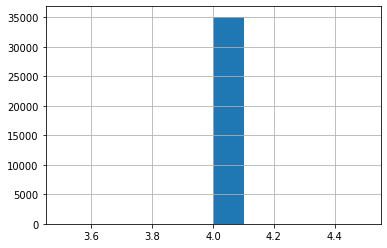

In [29]:
dfPredicted = pd.DataFrame({"Predict": test_predicted})
dfPredicted['Predict'].hist(bins=10)


In [30]:
mae = mean_absolute_error(dfValiTarget, test_predicted)

print("Average MAE: " + str(mae))
print("analyse_maes.append(" + str(mae) + ")")

Average MAE: 0.4599019635783294
analyse_maes.append(0.4599019635783294)


In [31]:

# print("Run: " + filePrefix)
# # Log of Results
# analyse_maes = []

# print("Average MAE over all tests: " + str(np.mean(analyse_maes)))

# Make sure it's predicting floats
# dfPredicted["Predict"].drop_duplicates()

Write to a subrun file

In [32]:
dfPredicted = pd.concat([dfValiIds.reset_index(), dfPredicted], axis=1).drop(columns="index")

if writeSubRunFile:
  dfPredicted.to_csv(subrunDir + filePrefix + "_subrun.csv", index=False)

print("Average MAE: " + str(mae))
print(dfPredicted.shape)
dfPredicted.sort_values("RowID").head(20)


Average MAE: 0.4599019635783294
(35089, 4)


,RowID,BeerID,ReviewerID,Predict
0,22,12300,2634,4.0
1,27,12300,5634,4.0
2,28,12300,3544,4.0
3,40,12300,6521,4.0
4,43,12300,10177,4.0
5,48,12300,2907,4.0
6,49,12300,1532,4.0
7,50,12300,3452,4.0
8,59,12300,6861,4.0
9,64,6699,6401,4.0


# Summary

No Param tuning
* Consumer Context and Review Counts
* MAE: 0.453666796514198
* Wrote to file: subruns\A3_063_lgbm_regression_consumercontext_subrun.csv

Consumer Context best params:
* Consumer Context and Review Counts
* Average MAE: 0.4599019635783294
